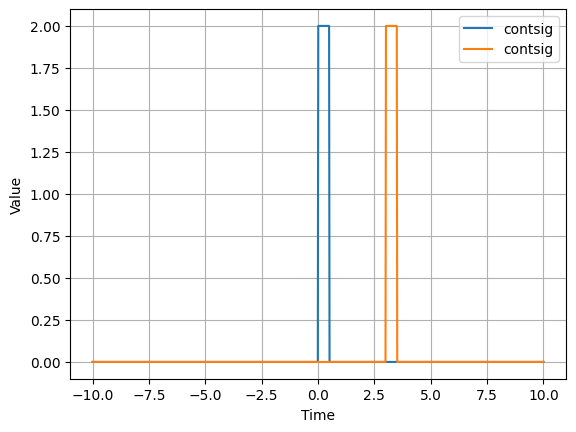

In [25]:
import numpy as np
import matplotlib.pyplot as plt



class ContinuousSignal:
    def __init__(self,func):
        self.func=func
    def add(self, other):
        # Creating a new ContinuousSignal with a combined function
        signal2 = ContinuousSignal(lambda x: self.func(x) + other.func(x))
        return signal2
    def shift_signal(self, shift):
        # Creating a new ContinuousSignal with a shifted function
        signal2 = ContinuousSignal(lambda x: self.func(x - shift))
        return signal2
    def multiply(self, other):
        # Creating a new ContinuousSignal with a multiplied function
        signal2 = ContinuousSignal(lambda x: self.func(x) * other.func(x))
        return signal2

    def multiply_const_factor(self, scaler):
        # Creating a new ContinuousSignal with a scaled function
        signal2 = ContinuousSignal(lambda x: self.func(x) * scaler)
        return signal2
    def plot(self, start, end, label):
        x = np.linspace(start, end, 1000)
        y = self.func(x)
        
        # Plot on the same figure with a label
        plt.plot(x, y, label=label)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.grid(True)

    @staticmethod
    def show():
        # Call the static method to show all the plots with a legend
        plt.legend()
        plt.show()
        
# def myfunc(x):
#     return 5*np.sin(x)
def youfunk(x):
    return x*x;
def unit_impulse(x):
    delta = 0.5
    impulse = np.zeros_like(x)  # Create an array of zeros with the same shape as x
    impulse[(x > 0) & (x < delta)] = 1 / delta  # Set the impulse value where the condition is met
    return impulse

contSig=ContinuousSignal(unit_impulse)
contSig2=contSig.shift_signal(3)
contSig.plot(-10,10,"contsig")


contSig2.plot(-10,10,"contsig")
ContinuousSignal.show()
# contSig.plot(-10,10,"contsig")
# contSig2=ContinuousSignal(youfunk)
# contSifted=contSig.shift_signal(1)
# contSifted2=contSig.shift_signal(-2)
# contSigAdd=contSig.add(contSig2)
# contSig.plot(-10,10,"contsig")    
# contSifted.plot(-10,10,"contsigshifted")
# contSifted2.plot(-10,10,"contsigshifted2")
# ContinuousSignal.show()

In [ ]:
class LTI_Continuous :
    def __init__(self,impulse_response):
        self.impulse_response=impulse_response
        
        